# Convolutional Blocks of ResNet18

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
import wandb
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Baseline - Training ResNet

### Dataset

In [3]:
# load the datasets
train_data = torch.load('dataset/train_data.pt')
train_labels = torch.load('dataset/train_labels.pt')
test_data = torch.load('dataset/test_data.pt')
test_labels = torch.load('dataset/test_labels.pt')

print(f"{train_data.shape=}")
print(f"{train_labels.shape=}")
print(f"{test_data.shape=}")
print(f"{test_labels.shape=}")

train_data.shape=torch.Size([50000, 3, 36, 36])
train_labels.shape=torch.Size([50000])
test_data.shape=torch.Size([10000, 3, 36, 36])
test_labels.shape=torch.Size([10000])


In [4]:
# convert to float and normalize
train_data = train_data.float() / 255
test_data = test_data.float() / 255

In [5]:
# custom dataset class
train_dataset = TensorDataset(train_data[:40000], train_labels[:40000])
val_dataset = TensorDataset(train_data[40000:], train_labels[40000:])
test_dataset = TensorDataset(test_data, test_labels)

In [6]:
# dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Loading Models

In [6]:
def get_model_no_weights():
    model = models.resnet18(weights=None).to(device)
    # update fc to have 10 outputs
    model.fc = nn.Linear(512, 10, bias=True).to(device)
    return model

In [7]:
def get_model_pretrained():
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
    # update fc to have 10 outputs
    model.fc = nn.Linear(512, 10, bias=True).to(device)
    return model

### Training and Evaluation

In [ ]:
# general training function
def train_model(model, train_loader, val_loader, max_epochs=15, log_wandb=''):
    if log_wandb:
        print("Logging to wandb...")
        wandb.init(project="resnet18", name=log_wandb, reinit=True)

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(model.parameters(), lr=0.001)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

    for epoch in range(max_epochs):
        # train
        model.train()
        train_loss = 0
        for data, target in tqdm(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
        train_loss /= len(train_loader)

        # evaluate
        model.eval()
        correct = 0
        total = 0
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)

                output = model(data)
                val_loss += criterion(output, target).item()
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        val_loss /= len(val_loader)
        accuracy = correct / total
        
        scheduler.step(val_loss)
        # print("lr", scheduler.get_last_lr())
        
        # print and log metrics
        if log_wandb:
            wandb.log({'train_loss': train_loss, 'val_loss': val_loss, 'val_accuracy': accuracy})
        print(f"Epoch {epoch+1}/{max_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.4f}")
        
    if log_wandb:
        wandb.finish()

In [9]:
# general evaluate function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    loss = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss += criterion(output, target).item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    loss /= len(test_loader)
    accuracy = correct / total
    print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

### Experiments

In [ ]:
# train model with no initial weights
model_no_weights = get_model_no_weights()
train_model(model_no_weights, train_loader, val_loader, log_wandb='baseline_no_weights')

Logging to wandb...


wandb: Currently logged in as: gauravbehera (gauravbehera-iiith) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


100%|██████████| 625/625 [00:04<00:00, 144.85it/s]


Epoch 1/15, Train Loss: 1.3847, Val Loss: 1.6290, Val Accuracy: 0.4708


100%|██████████| 625/625 [00:04<00:00, 153.14it/s]


Epoch 2/15, Train Loss: 0.9933, Val Loss: 0.9719, Val Accuracy: 0.6609


100%|██████████| 625/625 [00:04<00:00, 153.88it/s]


Epoch 3/15, Train Loss: 0.8049, Val Loss: 1.0638, Val Accuracy: 0.6515


100%|██████████| 625/625 [00:04<00:00, 154.00it/s]


Epoch 4/15, Train Loss: 0.6703, Val Loss: 0.7619, Val Accuracy: 0.7403


100%|██████████| 625/625 [00:04<00:00, 153.99it/s]


Epoch 5/15, Train Loss: 0.5476, Val Loss: 1.0063, Val Accuracy: 0.6803


100%|██████████| 625/625 [00:04<00:00, 153.99it/s]


Epoch 6/15, Train Loss: 0.4393, Val Loss: 0.8163, Val Accuracy: 0.7387


100%|██████████| 625/625 [00:04<00:00, 154.14it/s]


Epoch 7/15, Train Loss: 0.3409, Val Loss: 0.9016, Val Accuracy: 0.7388


100%|██████████| 625/625 [00:04<00:00, 154.15it/s]


Epoch 8/15, Train Loss: 0.1251, Val Loss: 0.7558, Val Accuracy: 0.7885


100%|██████████| 625/625 [00:04<00:00, 154.20it/s]


Epoch 9/15, Train Loss: 0.0601, Val Loss: 0.8488, Val Accuracy: 0.7870


100%|██████████| 625/625 [00:04<00:00, 153.89it/s]


Epoch 10/15, Train Loss: 0.0317, Val Loss: 0.9556, Val Accuracy: 0.7845


100%|██████████| 625/625 [00:04<00:00, 153.94it/s]


Epoch 11/15, Train Loss: 0.0179, Val Loss: 1.0749, Val Accuracy: 0.7844


100%|██████████| 625/625 [00:04<00:00, 153.66it/s]


Epoch 12/15, Train Loss: 0.0099, Val Loss: 1.0800, Val Accuracy: 0.7834


100%|██████████| 625/625 [00:04<00:00, 154.00it/s]


Epoch 13/15, Train Loss: 0.0078, Val Loss: 1.0997, Val Accuracy: 0.7846


100%|██████████| 625/625 [00:04<00:00, 153.96it/s]


Epoch 14/15, Train Loss: 0.0069, Val Loss: 1.1119, Val Accuracy: 0.7851


100%|██████████| 625/625 [00:04<00:00, 154.30it/s]


Epoch 15/15, Train Loss: 0.0060, Val Loss: 1.1170, Val Accuracy: 0.7866


In [16]:
print("Training Set")
evaluate_model(model_no_weights, train_loader)
print("Validation Set")
evaluate_model(model_no_weights, val_loader)
print("Test Set")
evaluate_model(model_no_weights, test_loader)

Training Set
Loss: 0.0024, Accuracy: 0.9999
Validation Set
Loss: 1.1170, Accuracy: 0.7866
Test Set
Loss: 1.1536, Accuracy: 0.7792


In [11]:
# train model with pretrained weights
model_pretrained = get_model_pretrained()
train_model(model_pretrained, train_loader, val_loader, log_wandb='baseline_pretrained')

Logging to wandb...


train_loss,█▆▅▄▄▃▃▂▁▁▁▁▁▁▁
val_accuracy,▁▅▅▇▆▇▇████████
val_loss,█▃▃▁▃▁▂▁▂▃▄▄▄▄▄
train_loss,0.00595
val_accuracy,0.7866
val_loss,1.11701


100%|██████████| 625/625 [00:04<00:00, 153.62it/s]


Epoch 1/15, Train Loss: 0.9052, Val Loss: 0.7647, Val Accuracy: 0.7447


100%|██████████| 625/625 [00:04<00:00, 153.57it/s]


Epoch 2/15, Train Loss: 0.6163, Val Loss: 0.8409, Val Accuracy: 0.7197


100%|██████████| 625/625 [00:04<00:00, 153.63it/s]


Epoch 3/15, Train Loss: 0.4813, Val Loss: 0.7522, Val Accuracy: 0.7578


100%|██████████| 625/625 [00:04<00:00, 153.83it/s]


Epoch 4/15, Train Loss: 0.3841, Val Loss: 0.6478, Val Accuracy: 0.7923


100%|██████████| 625/625 [00:04<00:00, 153.68it/s]


Epoch 5/15, Train Loss: 0.3023, Val Loss: 0.8044, Val Accuracy: 0.7485


100%|██████████| 625/625 [00:04<00:00, 153.99it/s]


Epoch 6/15, Train Loss: 0.2372, Val Loss: 0.7621, Val Accuracy: 0.7829


100%|██████████| 625/625 [00:04<00:00, 153.72it/s]


Epoch 7/15, Train Loss: 0.1977, Val Loss: 0.7084, Val Accuracy: 0.7996


100%|██████████| 625/625 [00:04<00:00, 153.81it/s]


Epoch 8/15, Train Loss: 0.0670, Val Loss: 0.6482, Val Accuracy: 0.8420


100%|██████████| 625/625 [00:04<00:00, 153.87it/s]


Epoch 9/15, Train Loss: 0.0229, Val Loss: 0.7365, Val Accuracy: 0.8416


100%|██████████| 625/625 [00:04<00:00, 153.90it/s]


Epoch 10/15, Train Loss: 0.0117, Val Loss: 0.8061, Val Accuracy: 0.8436


100%|██████████| 625/625 [00:04<00:00, 153.92it/s]


Epoch 11/15, Train Loss: 0.0059, Val Loss: 0.8180, Val Accuracy: 0.8440


100%|██████████| 625/625 [00:04<00:00, 153.94it/s]


Epoch 12/15, Train Loss: 0.0053, Val Loss: 0.8346, Val Accuracy: 0.8425


100%|██████████| 625/625 [00:04<00:00, 153.95it/s]


Epoch 13/15, Train Loss: 0.0043, Val Loss: 0.8326, Val Accuracy: 0.8436


100%|██████████| 625/625 [00:04<00:00, 153.92it/s]


Epoch 14/15, Train Loss: 0.0038, Val Loss: 0.8316, Val Accuracy: 0.8431


100%|██████████| 625/625 [00:04<00:00, 153.38it/s]


Epoch 15/15, Train Loss: 0.0039, Val Loss: 0.8341, Val Accuracy: 0.8440


In [17]:
print("Training Set")
evaluate_model(model_pretrained, train_loader)
print("Validation Set")
evaluate_model(model_pretrained, val_loader)
print("Test Set")
evaluate_model(model_pretrained, test_loader)

Training Set


Loss: 0.0010, Accuracy: 0.9999
Validation Set
Loss: 0.8341, Accuracy: 0.8440
Test Set
Loss: 0.8607, Accuracy: 0.8382


Plot of training loss, validation loss and accuracy over epochs.

![img](outputs/baseline_comparison.png)

Observations:
- The pretrained model has a lower validation loss and higher accuracy compared to the model trained from scratch. 
- The pretrained model starts with a lower training loss. 
- The pretrained ResNet18 achieves better accuracy and stability due to learned features from ImageNet.

### Dimensions

In [20]:
# resnet architecture
model = get_model_pretrained()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# print shape at each layer
x = torch.randn(64, 3, 36, 36).float().to(device)
for layer in model.children():
    x = layer(x)
    layer_name = layer.__class__.__name__
    print(f"{layer_name} : {x.shape}")
    if layer_name == "AdaptiveAvgPool2d":
        x = torch.flatten(x, 1)

Conv2d : torch.Size([64, 64, 18, 18])
BatchNorm2d : torch.Size([64, 64, 18, 18])
ReLU : torch.Size([64, 64, 18, 18])
MaxPool2d : torch.Size([64, 64, 9, 9])
Sequential : torch.Size([64, 64, 9, 9])
Sequential : torch.Size([64, 128, 5, 5])
Sequential : torch.Size([64, 256, 3, 3])
Sequential : torch.Size([64, 512, 2, 2])
AdaptiveAvgPool2d : torch.Size([64, 512, 1, 1])
Linear : torch.Size([64, 10])


The spatial dimensions of image before the average pooling layer in ResNet18 is 2x2.

The ResNet18 model has multiple convolutional blocks which increase the receptive field. The initial layers capture low-level features like edges and textures. The later layers capture high-level features like shapes and patterns. 

## Training ResNet on resized images

In [9]:
# reshape images to 224x224
train_data_224 = F.interpolate(train_data, size=(224, 224))
test_data_224 = F.interpolate(test_data, size=(224, 224))

train_dataset_224 = TensorDataset(train_data_224[:40000], train_labels[:40000])
val_dataset_224 = TensorDataset(train_data_224[40000:], train_labels[40000:])
test_dataset_224 = TensorDataset(test_data_224, test_labels)

train_loader_224 = DataLoader(train_dataset_224, batch_size=32, shuffle=True)
val_loader_224 = DataLoader(val_dataset_224, batch_size=32, shuffle=False)
test_loader_224 = DataLoader(test_dataset_224, batch_size=32, shuffle=False)

In [10]:
# train model with no initial weights
model_no_weights_resized = get_model_no_weights()
train_model(model_no_weights_resized, train_loader_224, val_loader_224, log_wandb='resized_no_weights')

Logging to wandb...


wandb: Currently logged in as: gauravbehera (gauravbehera-iiith) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


100%|██████████| 1250/1250 [00:31<00:00, 39.68it/s]


Epoch 1/15, Train Loss: 1.4375, Val Loss: 1.1523, Val Accuracy: 0.5987


100%|██████████| 1250/1250 [00:31<00:00, 40.11it/s]


Epoch 2/15, Train Loss: 0.9099, Val Loss: 0.8809, Val Accuracy: 0.6957


100%|██████████| 1250/1250 [00:31<00:00, 39.84it/s]


Epoch 3/15, Train Loss: 0.7050, Val Loss: 0.6315, Val Accuracy: 0.7806


100%|██████████| 1250/1250 [00:31<00:00, 39.75it/s]


Epoch 4/15, Train Loss: 0.5644, Val Loss: 0.7017, Val Accuracy: 0.7655


100%|██████████| 1250/1250 [00:31<00:00, 39.70it/s]


Epoch 5/15, Train Loss: 0.4600, Val Loss: 0.5374, Val Accuracy: 0.8152


100%|██████████| 1250/1250 [00:31<00:00, 39.76it/s]


Epoch 6/15, Train Loss: 0.3649, Val Loss: 0.5625, Val Accuracy: 0.8106


100%|██████████| 1250/1250 [00:31<00:00, 39.77it/s]


Epoch 7/15, Train Loss: 0.2668, Val Loss: 0.5571, Val Accuracy: 0.8226


100%|██████████| 1250/1250 [00:31<00:00, 39.76it/s]


Epoch 8/15, Train Loss: 0.1942, Val Loss: 0.5848, Val Accuracy: 0.8317


100%|██████████| 1250/1250 [00:31<00:00, 39.71it/s]


Epoch 9/15, Train Loss: 0.0612, Val Loss: 0.4880, Val Accuracy: 0.8594


100%|██████████| 1250/1250 [00:31<00:00, 39.71it/s]


Epoch 10/15, Train Loss: 0.0295, Val Loss: 0.5093, Val Accuracy: 0.8588


100%|██████████| 1250/1250 [00:31<00:00, 39.69it/s]


Epoch 11/15, Train Loss: 0.0186, Val Loss: 0.5459, Val Accuracy: 0.8597


100%|██████████| 1250/1250 [00:31<00:00, 39.66it/s]


Epoch 12/15, Train Loss: 0.0125, Val Loss: 0.5713, Val Accuracy: 0.8603


100%|██████████| 1250/1250 [00:31<00:00, 39.65it/s]


Epoch 13/15, Train Loss: 0.0076, Val Loss: 0.5694, Val Accuracy: 0.8620


100%|██████████| 1250/1250 [00:31<00:00, 39.27it/s]


Epoch 14/15, Train Loss: 0.0062, Val Loss: 0.5688, Val Accuracy: 0.8604


100%|██████████| 1250/1250 [00:32<00:00, 38.07it/s]


Epoch 15/15, Train Loss: 0.0061, Val Loss: 0.5714, Val Accuracy: 0.8585


train_loss,█▅▄▄▃▃▂▂▁▁▁▁▁▁▁
val_accuracy,▁▄▆▅▇▇▇▇███████
val_loss,█▅▃▃▂▂▂▂▁▁▂▂▂▂▂
train_loss,0.0061
val_accuracy,0.8585
val_loss,0.5714


In [11]:
print("Training Set")
evaluate_model(model_no_weights_resized, train_loader_224)
print("Validation Set")
evaluate_model(model_no_weights_resized, val_loader_224)
print("Test Set")
evaluate_model(model_no_weights_resized, test_loader_224)

Training Set
Loss: 0.0019, Accuracy: 1.0000
Validation Set
Loss: 0.5714, Accuracy: 0.8585
Test Set
Loss: 0.5799, Accuracy: 0.8532


In [10]:
# train model with pretrained weights
model_pretrained_resized = get_model_pretrained()
train_model(model_pretrained_resized, train_loader_224, val_loader_224, log_wandb='resized_pretrained')

Logging to wandb...


wandb: Currently logged in as: gauravbehera (gauravbehera-iiith) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


100%|██████████| 1250/1250 [00:31<00:00, 39.82it/s]


Epoch 1/15, Train Loss: 0.7429, Val Loss: 0.5350, Val Accuracy: 0.8163


100%|██████████| 1250/1250 [00:31<00:00, 40.15it/s]


Epoch 2/15, Train Loss: 0.4521, Val Loss: 0.4829, Val Accuracy: 0.8365


100%|██████████| 1250/1250 [00:31<00:00, 40.01it/s]


Epoch 3/15, Train Loss: 0.3265, Val Loss: 0.3619, Val Accuracy: 0.8759


100%|██████████| 1250/1250 [00:31<00:00, 39.89it/s]


Epoch 4/15, Train Loss: 0.2463, Val Loss: 0.4724, Val Accuracy: 0.8524


100%|██████████| 1250/1250 [00:31<00:00, 39.83it/s]


Epoch 5/15, Train Loss: 0.1836, Val Loss: 0.3648, Val Accuracy: 0.8849


100%|██████████| 1250/1250 [00:31<00:00, 39.80it/s]


Epoch 6/15, Train Loss: 0.1364, Val Loss: 0.4527, Val Accuracy: 0.8701


100%|██████████| 1250/1250 [00:31<00:00, 39.86it/s]


Epoch 7/15, Train Loss: 0.0418, Val Loss: 0.2859, Val Accuracy: 0.9147


100%|██████████| 1250/1250 [00:31<00:00, 39.82it/s]


Epoch 8/15, Train Loss: 0.0125, Val Loss: 0.2989, Val Accuracy: 0.9156


100%|██████████| 1250/1250 [00:31<00:00, 39.84it/s]


Epoch 9/15, Train Loss: 0.0069, Val Loss: 0.3115, Val Accuracy: 0.9168


100%|██████████| 1250/1250 [00:31<00:00, 39.83it/s]


Epoch 10/15, Train Loss: 0.0040, Val Loss: 0.3191, Val Accuracy: 0.9177


100%|██████████| 1250/1250 [00:31<00:00, 39.84it/s]


Epoch 11/15, Train Loss: 0.0030, Val Loss: 0.3186, Val Accuracy: 0.9175


100%|██████████| 1250/1250 [00:31<00:00, 39.82it/s]


Epoch 12/15, Train Loss: 0.0022, Val Loss: 0.3224, Val Accuracy: 0.9175


100%|██████████| 1250/1250 [00:31<00:00, 39.49it/s]


Epoch 13/15, Train Loss: 0.0018, Val Loss: 0.3271, Val Accuracy: 0.9178


100%|██████████| 1250/1250 [00:31<00:00, 39.49it/s]


Epoch 14/15, Train Loss: 0.0015, Val Loss: 0.3266, Val Accuracy: 0.9190


100%|██████████| 1250/1250 [00:31<00:00, 39.46it/s]


Epoch 15/15, Train Loss: 0.0014, Val Loss: 0.3254, Val Accuracy: 0.9190


train_loss,█▅▄▃▃▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▅▃▆▅█████████
val_loss,█▇▃▆▃▆▁▁▂▂▂▂▂▂▂
train_loss,0.00142
val_accuracy,0.919
val_loss,0.32536


In [11]:
print("Training Set")
evaluate_model(model_pretrained_resized, train_loader_224)
print("Validation Set")
evaluate_model(model_pretrained_resized, val_loader_224)    
print("Test Set")
evaluate_model(model_pretrained_resized, test_loader_224)

Training Set
Loss: 0.0003, Accuracy: 1.0000
Validation Set
Loss: 0.3254, Accuracy: 0.9190
Test Set
Loss: 0.3411, Accuracy: 0.9189


Plot of training loss, validation loss and accuracy over epochs.

![img](outputs/resized_comparison.png)

Observations:
- The pretrained model has a lower validation loss and higher accuracy compared to the model trained from scratch. 
- The pretrained model starts with a lower training loss. 
- The pretrained ResNet18 achieves better accuracy and stability due to learned features from ImageNet.

| Model | Image Size | Accuracy |
| --- | --- | --- |
| Random Init | 32x32 | 77.92% |
| Random Init | 224x224 | 85.32% |
| Pretrained | 32x32 | 83.82% |
| Pretrained | 224x224 | 91.89% |

**Comparison**
- The pretrained model achieves better accuracy compared to the model trained from scratch in both cases of image sizes.
- The models trained on 224x224 images has higher accuracy compared to the models trained on 32x32 images. This is because the model actually gets to convolutional layers to extract spatial features from the images. 
- The models trained on 224x224 images take longer to train compared to the models trained on 32x32 images. This happens as the convolutional layers have to process more pixels in the image.

**Time Comparison**
- The models trained on 32x32 images take 60 seconds to train for 15 epochs.
- The models trained on 224x224 images take 470 seconds to train for 15 epochs.
- The models trained on 224x224 images take 8 times longer to train compared to the models trained on 32x32 images while the accuracy is only 5% higher.

## Modifying the architecture of ResNet18 to suit the given dataset

### Default Architecture
conv1 : kernel_size=(7,7), stride=(2,2) \
maxpool : kernel_size=3, stride=2

In [10]:
# dataloaders
train_loader_small = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_small = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader_small = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
def evaluate_modified_model(model, test_loader):
    model.eval()
    loss = 0
    true_values = []
    predicted_values = []
    criterion = nn.CrossEntropyLoss()
    # accuracy, precision, recall, f1
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += criterion(output, target).item()
            _, predicted = torch.max(output.data, 1)
            true_values.extend(target.cpu().numpy())
            predicted_values.extend(predicted.cpu().numpy())
            
    loss /= len(test_loader)
    accuracy = accuracy_score(true_values, predicted_values)
    precision = precision_score(true_values, predicted_values, average="macro")
    recall = recall_score(true_values, predicted_values, average="macro")
    f1 = f1_score(true_values, predicted_values, average="macro")
    print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    # confusion matrix
    cm = confusion_matrix(true_values, predicted_values)
    plt.imshow(cm, interpolation='nearest')
    plt.colorbar()
    plt.title("Confusion Matrix")
    plt.show()

### Random Initialization

Modification 1 - kernel_size=(3,3) and stride=(1,1) in conv1

Logging to wandb...


100%|██████████| 1250/1250 [00:15<00:00, 80.08it/s]


Epoch 1/15, Train Loss: 1.3489, Val Loss: 1.1895, Val Accuracy: 0.5905


100%|██████████| 1250/1250 [00:15<00:00, 81.98it/s]


Epoch 2/15, Train Loss: 0.9255, Val Loss: 0.8554, Val Accuracy: 0.7063


100%|██████████| 1250/1250 [00:15<00:00, 81.78it/s]


Epoch 3/15, Train Loss: 0.7234, Val Loss: 0.7870, Val Accuracy: 0.7291


100%|██████████| 1250/1250 [00:15<00:00, 81.74it/s]


Epoch 4/15, Train Loss: 0.5705, Val Loss: 0.8006, Val Accuracy: 0.7394


100%|██████████| 1250/1250 [00:15<00:00, 81.50it/s]


Epoch 5/15, Train Loss: 0.4420, Val Loss: 0.9516, Val Accuracy: 0.7046


100%|██████████| 1250/1250 [00:15<00:00, 81.81it/s]


Epoch 6/15, Train Loss: 0.3333, Val Loss: 0.6614, Val Accuracy: 0.7897


100%|██████████| 1250/1250 [00:15<00:00, 80.58it/s]


Epoch 7/15, Train Loss: 0.2327, Val Loss: 0.7840, Val Accuracy: 0.7768


100%|██████████| 1250/1250 [00:15<00:00, 81.46it/s]


Epoch 8/15, Train Loss: 0.1680, Val Loss: 0.9682, Val Accuracy: 0.7611


100%|██████████| 1250/1250 [00:15<00:00, 81.61it/s]


Epoch 9/15, Train Loss: 0.1305, Val Loss: 0.8790, Val Accuracy: 0.7807


100%|██████████| 1250/1250 [00:15<00:00, 81.37it/s]


Epoch 10/15, Train Loss: 0.0335, Val Loss: 0.7124, Val Accuracy: 0.8272


100%|██████████| 1250/1250 [00:15<00:00, 80.65it/s]


Epoch 11/15, Train Loss: 0.0114, Val Loss: 0.7602, Val Accuracy: 0.8308


100%|██████████| 1250/1250 [00:15<00:00, 81.13it/s]


Epoch 12/15, Train Loss: 0.0057, Val Loss: 0.8179, Val Accuracy: 0.8296


100%|██████████| 1250/1250 [00:15<00:00, 81.30it/s]


Epoch 13/15, Train Loss: 0.0029, Val Loss: 0.8102, Val Accuracy: 0.8287


100%|██████████| 1250/1250 [00:15<00:00, 81.02it/s]


Epoch 14/15, Train Loss: 0.0028, Val Loss: 0.8157, Val Accuracy: 0.8303


100%|██████████| 1250/1250 [00:15<00:00, 81.43it/s]


Epoch 15/15, Train Loss: 0.0023, Val Loss: 0.8242, Val Accuracy: 0.8308


train_loss,█▆▅▄▃▃▂▂▂▁▁▁▁▁▁
val_accuracy,▁▄▅▅▄▇▆▆▇██████
val_loss,█▄▃▃▅▁▃▅▄▂▂▃▃▃▃
train_loss,0.0023
val_accuracy,0.8308
val_loss,0.82418


Train Set
Loss: 0.0007, Accuracy: 1.0000
Validation Set
Loss: 0.8242, Accuracy: 0.8308
Test Set
Loss: 0.8582, Accuracy: 0.8235, Precision: 0.8234, Recall: 0.8235, F1: 0.8232


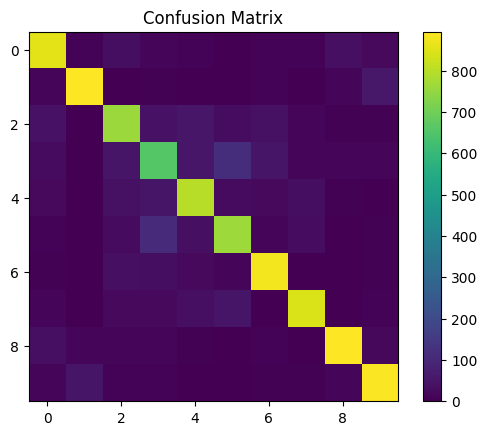

In [25]:
model_no_weights_mod1 = get_model_no_weights()
model_no_weights_mod1.conv1 = nn.Conv2d(3, 64, kernel_size=(3,3), stride=(1, 1), padding=(3, 3), bias=False).to(device)

# training
train_model(model_no_weights_mod1, train_loader_small, val_loader_small, log_wandb='no_weights_mod1')

# evaluation
print("Train Set")
evaluate_model(model_no_weights_mod1, train_loader_small)
print("Validation Set")
evaluate_model(model_no_weights_mod1, val_loader_small)
print("Test Set")
evaluate_modified_model(model_no_weights_mod1, test_loader_small)

Modification 2 - kernel_size=1, stride=1 in maxpool

Logging to wandb...


100%|██████████| 1250/1250 [00:14<00:00, 85.46it/s]


Epoch 1/15, Train Loss: 1.4565, Val Loss: 1.1964, Val Accuracy: 0.5704


100%|██████████| 1250/1250 [00:14<00:00, 86.80it/s]


Epoch 2/15, Train Loss: 1.0080, Val Loss: 1.0093, Val Accuracy: 0.6456


100%|██████████| 1250/1250 [00:14<00:00, 86.44it/s]


Epoch 3/15, Train Loss: 0.7755, Val Loss: 0.7640, Val Accuracy: 0.7304


100%|██████████| 1250/1250 [00:14<00:00, 86.38it/s]


Epoch 4/15, Train Loss: 0.6070, Val Loss: 0.7501, Val Accuracy: 0.7426


100%|██████████| 1250/1250 [00:14<00:00, 85.84it/s]


Epoch 5/15, Train Loss: 0.4674, Val Loss: 0.7409, Val Accuracy: 0.7557


100%|██████████| 1250/1250 [00:14<00:00, 86.12it/s]


Epoch 6/15, Train Loss: 0.3433, Val Loss: 0.7157, Val Accuracy: 0.7744


100%|██████████| 1250/1250 [00:14<00:00, 85.65it/s]


Epoch 7/15, Train Loss: 0.2291, Val Loss: 0.8139, Val Accuracy: 0.7659


100%|██████████| 1250/1250 [00:14<00:00, 84.79it/s]


Epoch 8/15, Train Loss: 0.1611, Val Loss: 0.9297, Val Accuracy: 0.7627


100%|██████████| 1250/1250 [00:14<00:00, 85.15it/s]


Epoch 9/15, Train Loss: 0.1239, Val Loss: 0.9369, Val Accuracy: 0.7687


100%|██████████| 1250/1250 [00:14<00:00, 85.13it/s]


Epoch 10/15, Train Loss: 0.0361, Val Loss: 0.8535, Val Accuracy: 0.7989


100%|██████████| 1250/1250 [00:14<00:00, 85.69it/s]


Epoch 11/15, Train Loss: 0.0117, Val Loss: 0.9180, Val Accuracy: 0.8006


100%|██████████| 1250/1250 [00:14<00:00, 85.62it/s]


Epoch 12/15, Train Loss: 0.0058, Val Loss: 1.0102, Val Accuracy: 0.7984


100%|██████████| 1250/1250 [00:14<00:00, 84.56it/s]


Epoch 13/15, Train Loss: 0.0034, Val Loss: 1.0078, Val Accuracy: 0.8015


100%|██████████| 1250/1250 [00:14<00:00, 85.26it/s]


Epoch 14/15, Train Loss: 0.0028, Val Loss: 1.0211, Val Accuracy: 0.8000


100%|██████████| 1250/1250 [00:14<00:00, 84.33it/s]


Epoch 15/15, Train Loss: 0.0027, Val Loss: 1.0325, Val Accuracy: 0.8010


train_loss,█▆▅▄▃▃▂▂▂▁▁▁▁▁▁
val_accuracy,▁▃▆▆▇▇▇▇▇██████
val_loss,█▅▂▂▁▁▂▄▄▃▄▅▅▅▆
train_loss,0.00271
val_accuracy,0.801
val_loss,1.03248


Train Set
Loss: 0.0006, Accuracy: 1.0000
Validation Set
Loss: 1.0325, Accuracy: 0.8010
Test Set
Loss: 1.0700, Accuracy: 0.7965, Precision: 0.7962, Recall: 0.7965, F1: 0.7963


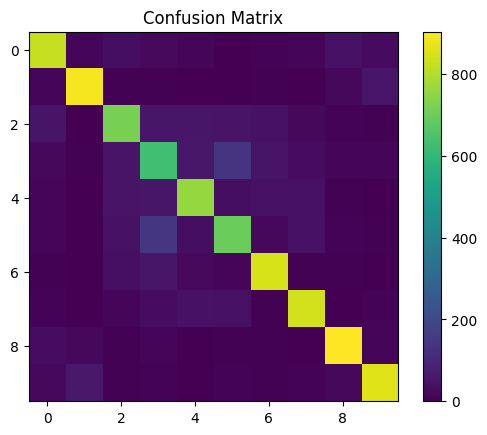

In [26]:
model_no_weights_mod2 = get_model_no_weights()
model_no_weights_mod2.maxpool = nn.MaxPool2d(kernel_size=1, stride=1)

# training
train_model(model_no_weights_mod2, train_loader_small, val_loader_small, log_wandb='no_weights_mod2')

# evaluation
print("Train Set")
evaluate_model(model_no_weights_mod2, train_loader_small)
print("Validation Set")
evaluate_model(model_no_weights_mod2, val_loader_small)
print("Test Set")
evaluate_modified_model(model_no_weights_mod2, test_loader_small)

Modification 3 - Modification 1 + Modification 2

Logging to wandb...


100%|██████████| 1250/1250 [00:26<00:00, 47.12it/s]


Epoch 1/15, Train Loss: 1.4582, Val Loss: 1.1550, Val Accuracy: 0.5863


100%|██████████| 1250/1250 [00:26<00:00, 47.04it/s]


Epoch 2/15, Train Loss: 0.9628, Val Loss: 0.7901, Val Accuracy: 0.7229


100%|██████████| 1250/1250 [00:26<00:00, 47.06it/s]


Epoch 3/15, Train Loss: 0.7277, Val Loss: 0.6529, Val Accuracy: 0.7718


100%|██████████| 1250/1250 [00:26<00:00, 47.01it/s]


Epoch 4/15, Train Loss: 0.5808, Val Loss: 0.6330, Val Accuracy: 0.7789


100%|██████████| 1250/1250 [00:26<00:00, 47.01it/s]


Epoch 5/15, Train Loss: 0.4634, Val Loss: 0.5897, Val Accuracy: 0.8015


100%|██████████| 1250/1250 [00:26<00:00, 47.02it/s]


Epoch 6/15, Train Loss: 0.3610, Val Loss: 0.5642, Val Accuracy: 0.8150


100%|██████████| 1250/1250 [00:26<00:00, 47.02it/s]


Epoch 7/15, Train Loss: 0.2782, Val Loss: 0.5533, Val Accuracy: 0.8229


100%|██████████| 1250/1250 [00:26<00:00, 47.05it/s]


Epoch 8/15, Train Loss: 0.1931, Val Loss: 0.6147, Val Accuracy: 0.8195


100%|██████████| 1250/1250 [00:26<00:00, 47.01it/s]


Epoch 9/15, Train Loss: 0.1475, Val Loss: 0.6597, Val Accuracy: 0.8166


100%|██████████| 1250/1250 [00:26<00:00, 47.01it/s]


Epoch 10/15, Train Loss: 0.1036, Val Loss: 0.7404, Val Accuracy: 0.8160


100%|██████████| 1250/1250 [00:26<00:00, 46.87it/s]


Epoch 11/15, Train Loss: 0.0321, Val Loss: 0.6079, Val Accuracy: 0.8498


100%|██████████| 1250/1250 [00:26<00:00, 47.01it/s]


Epoch 12/15, Train Loss: 0.0125, Val Loss: 0.6431, Val Accuracy: 0.8480


100%|██████████| 1250/1250 [00:26<00:00, 46.99it/s]


Epoch 13/15, Train Loss: 0.0068, Val Loss: 0.6861, Val Accuracy: 0.8477


100%|██████████| 1250/1250 [00:26<00:00, 46.90it/s]


Epoch 14/15, Train Loss: 0.0046, Val Loss: 0.6928, Val Accuracy: 0.8508


100%|██████████| 1250/1250 [00:26<00:00, 46.76it/s]


Epoch 15/15, Train Loss: 0.0039, Val Loss: 0.6895, Val Accuracy: 0.8508


train_loss,█▆▄▄▃▃▂▂▂▁▁▁▁▁▁
val_accuracy,▁▅▆▆▇▇▇▇▇▇█████
val_loss,█▄▂▂▁▁▁▂▂▃▂▂▃▃▃
train_loss,0.00394
val_accuracy,0.8508
val_loss,0.68954


Train Set
Loss: 0.0011, Accuracy: 1.0000
Validation Set
Loss: 0.6895, Accuracy: 0.8508
Test Set
Loss: 0.6852, Accuracy: 0.8499, Precision: 0.8496, Recall: 0.8499, F1: 0.8494


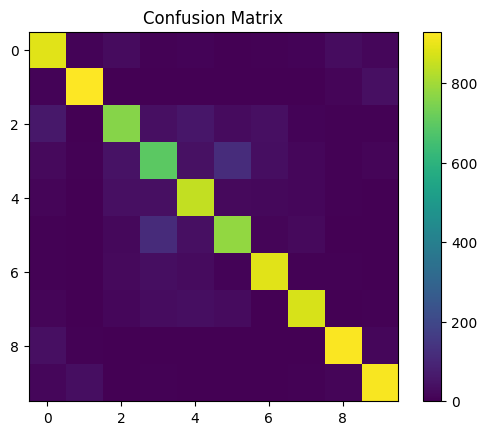

In [27]:
model_no_weights_mod3 = get_model_no_weights()
model_no_weights_mod3.conv1 = nn.Conv2d(3, 64, kernel_size=(3,3), stride=(1, 1), padding=(3, 3), bias=False).to(device)
model_no_weights_mod3.maxpool = nn.MaxPool2d(kernel_size=1, stride=1)

# training
train_model(model_no_weights_mod3, train_loader_small, val_loader_small, log_wandb='no_weights_mod3')

# evaluation
print("Train Set")
evaluate_model(model_no_weights_mod3, train_loader_small)
print("Validation Set")
evaluate_model(model_no_weights_mod3, val_loader_small)
print("Test Set")
evaluate_modified_model(model_no_weights_mod3, test_loader_small)

Modifications:
1. Reducing kernel size and stride in the first convolutional layer helps in capturing more spatial features from the image. This leads to significant improvement in accuracy.
2. Updating the maxpool layer to have kernel size 1 and stride 1, basically removing the maxpool layer, helps in retaining spatial information in the image. This leads to a slight improvement in accuracy.
3. Combining both modifications 1 and 2 leads to the best accuracy.

Observations:
- THe conv1 update is more effective in improving accuracy compared to the maxpool update.
- The model with both modifications has the highest accuracy.

![img](outputs/baseline_mods_comparison.png)

### Pretrained Weights as Initialization

Modification 1 - kernel_size=(3,3) and stride=(1,1) in conv1

Logging to wandb...


100%|██████████| 1250/1250 [00:14<00:00, 84.67it/s]


Epoch 1/15, Train Loss: 1.2057, Val Loss: 1.0442, Val Accuracy: 0.6350


100%|██████████| 1250/1250 [00:14<00:00, 87.82it/s]


Epoch 2/15, Train Loss: 0.7428, Val Loss: 0.7048, Val Accuracy: 0.7555


100%|██████████| 1250/1250 [00:14<00:00, 87.60it/s]


Epoch 3/15, Train Loss: 0.5423, Val Loss: 0.6645, Val Accuracy: 0.7780


100%|██████████| 1250/1250 [00:14<00:00, 88.06it/s]


Epoch 4/15, Train Loss: 0.3960, Val Loss: 0.6710, Val Accuracy: 0.7787


100%|██████████| 1250/1250 [00:14<00:00, 87.67it/s]


Epoch 5/15, Train Loss: 0.2826, Val Loss: 0.7010, Val Accuracy: 0.7841


100%|██████████| 1250/1250 [00:14<00:00, 83.58it/s]


Epoch 6/15, Train Loss: 0.1306, Val Loss: 0.6607, Val Accuracy: 0.8118


100%|██████████| 1250/1250 [00:14<00:00, 88.10it/s]


Epoch 7/15, Train Loss: 0.0705, Val Loss: 0.6911, Val Accuracy: 0.8122


100%|██████████| 1250/1250 [00:14<00:00, 87.44it/s]


Epoch 8/15, Train Loss: 0.0479, Val Loss: 0.7349, Val Accuracy: 0.8159


100%|██████████| 1250/1250 [00:14<00:00, 87.81it/s]


Epoch 9/15, Train Loss: 0.0284, Val Loss: 0.7380, Val Accuracy: 0.8187


100%|██████████| 1250/1250 [00:14<00:00, 87.38it/s]


Epoch 10/15, Train Loss: 0.0209, Val Loss: 0.7516, Val Accuracy: 0.8191


100%|██████████| 1250/1250 [00:14<00:00, 87.40it/s]


Epoch 11/15, Train Loss: 0.0160, Val Loss: 0.7571, Val Accuracy: 0.8203


100%|██████████| 1250/1250 [00:14<00:00, 84.68it/s]


Epoch 12/15, Train Loss: 0.0144, Val Loss: 0.7679, Val Accuracy: 0.8195


100%|██████████| 1250/1250 [00:14<00:00, 87.73it/s]


Epoch 13/15, Train Loss: 0.0135, Val Loss: 0.7667, Val Accuracy: 0.8234


100%|██████████| 1250/1250 [00:14<00:00, 88.13it/s]


Epoch 14/15, Train Loss: 0.0129, Val Loss: 0.7680, Val Accuracy: 0.8223


100%|██████████| 1250/1250 [00:14<00:00, 87.70it/s]


Epoch 15/15, Train Loss: 0.0120, Val Loss: 0.7747, Val Accuracy: 0.8194


train_loss,█▅▄▃▃▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▆▇██████████
val_loss,█▂▁▁▂▁▂▂▂▃▃▃▃▃▃
train_loss,0.01202
val_accuracy,0.8194
val_loss,0.77474


Train Set
Loss: 0.0016, Accuracy: 1.0000
Validation Set
Loss: 0.7747, Accuracy: 0.8194
Test Set
Loss: 0.7825, Accuracy: 0.8181, Precision: 0.8199, Recall: 0.8181, F1: 0.8188


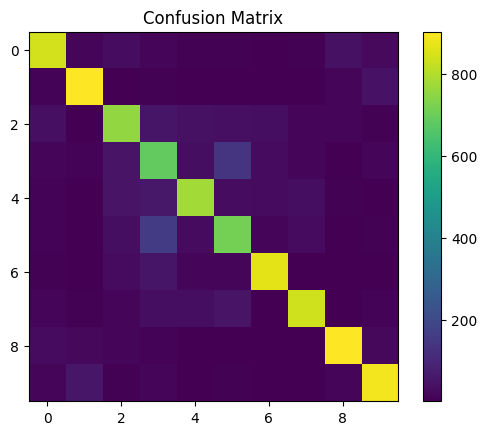

In [15]:
model_pretrained_mod1 = get_model_pretrained()
model_pretrained_mod1.conv1 = nn.Conv2d(3, 64, kernel_size=(3,3), stride=(1, 1), padding=(3, 3), bias=False).to(device)

# training
train_model(model_pretrained_mod1, train_loader_small, val_loader_small, log_wandb='pretrained_mod1')

# evaluation
print("Train Set")
evaluate_model(model_pretrained_mod1, train_loader_small)
print("Validation Set")
evaluate_model(model_pretrained_mod1, val_loader_small)
print("Test Set")
evaluate_modified_model(model_pretrained_mod1, test_loader_small)

Modification 2 - kernel_size=1, stride=1 in maxpool

Logging to wandb...


100%|██████████| 1250/1250 [00:14<00:00, 83.62it/s]


Epoch 1/15, Train Loss: 0.8236, Val Loss: 0.4888, Val Accuracy: 0.8319


100%|██████████| 1250/1250 [00:13<00:00, 92.75it/s]


Epoch 2/15, Train Loss: 0.3985, Val Loss: 0.3970, Val Accuracy: 0.8682


100%|██████████| 1250/1250 [00:13<00:00, 93.05it/s]


Epoch 3/15, Train Loss: 0.2331, Val Loss: 0.3955, Val Accuracy: 0.8730


100%|██████████| 1250/1250 [00:14<00:00, 84.61it/s]


Epoch 4/15, Train Loss: 0.1479, Val Loss: 0.4400, Val Accuracy: 0.8766


100%|██████████| 1250/1250 [00:13<00:00, 93.11it/s]


Epoch 5/15, Train Loss: 0.0858, Val Loss: 0.4288, Val Accuracy: 0.8774


100%|██████████| 1250/1250 [00:13<00:00, 93.17it/s]


Epoch 6/15, Train Loss: 0.0435, Val Loss: 0.4068, Val Accuracy: 0.8893


100%|██████████| 1250/1250 [00:13<00:00, 93.17it/s]


Epoch 7/15, Train Loss: 0.0227, Val Loss: 0.4169, Val Accuracy: 0.8902


100%|██████████| 1250/1250 [00:13<00:00, 89.60it/s]


Epoch 8/15, Train Loss: 0.0161, Val Loss: 0.4201, Val Accuracy: 0.8941


100%|██████████| 1250/1250 [00:13<00:00, 93.18it/s]


Epoch 9/15, Train Loss: 0.0129, Val Loss: 0.4243, Val Accuracy: 0.8934


100%|██████████| 1250/1250 [00:14<00:00, 85.20it/s]


Epoch 10/15, Train Loss: 0.0114, Val Loss: 0.4237, Val Accuracy: 0.8946


100%|██████████| 1250/1250 [00:14<00:00, 83.48it/s]


Epoch 11/15, Train Loss: 0.0100, Val Loss: 0.4248, Val Accuracy: 0.8954


100%|██████████| 1250/1250 [00:13<00:00, 93.05it/s]


Epoch 12/15, Train Loss: 0.0092, Val Loss: 0.4309, Val Accuracy: 0.8948


100%|██████████| 1250/1250 [00:15<00:00, 83.33it/s]


Epoch 13/15, Train Loss: 0.0089, Val Loss: 0.4290, Val Accuracy: 0.8954


100%|██████████| 1250/1250 [00:13<00:00, 92.81it/s]


Epoch 14/15, Train Loss: 0.0080, Val Loss: 0.4325, Val Accuracy: 0.8940


100%|██████████| 1250/1250 [00:15<00:00, 79.76it/s]


Epoch 15/15, Train Loss: 0.0085, Val Loss: 0.4281, Val Accuracy: 0.8959


train_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▆▆▇▇████████
val_loss,█▁▁▄▃▂▃▃▃▃▃▄▄▄▃
train_loss,0.0085
val_accuracy,0.8959
val_loss,0.42809


Train Set
Loss: 0.0007, Accuracy: 1.0000
Validation Set
Loss: 0.4281, Accuracy: 0.8959
Test Set
Loss: 0.4435, Accuracy: 0.8917, Precision: 0.8914, Recall: 0.8917, F1: 0.8915


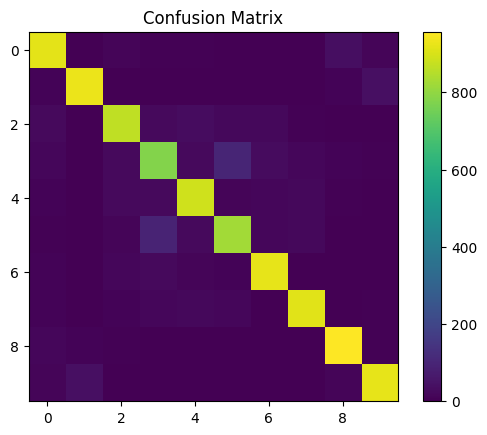

In [14]:
model_pretrained_mod2 = get_model_pretrained()
model_pretrained_mod2.maxpool = nn.MaxPool2d(kernel_size=1, stride=1)

# training
train_model(model_pretrained_mod2, train_loader_small, val_loader_small, log_wandb='pretrained_mod2')

# evaluation
print("Train Set")
evaluate_model(model_pretrained_mod2, train_loader_small)
print("Validation Set")
evaluate_model(model_pretrained_mod2, val_loader_small)
print("Test Set")
evaluate_modified_model(model_pretrained_mod2, test_loader_small)

Modification 3 - Modification 1 + Modification 2

Logging to wandb...


wandb: Currently logged in as: gauravbehera (gauravbehera-iiith) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


100%|██████████| 1250/1250 [00:25<00:00, 49.82it/s]


Epoch 1/15, Train Loss: 0.8857, Val Loss: 0.4626, Val Accuracy: 0.8425


100%|██████████| 1250/1250 [00:23<00:00, 54.13it/s]


Epoch 2/15, Train Loss: 0.3886, Val Loss: 0.3509, Val Accuracy: 0.8795


100%|██████████| 1250/1250 [00:23<00:00, 53.73it/s]


Epoch 3/15, Train Loss: 0.2273, Val Loss: 0.3204, Val Accuracy: 0.8909


100%|██████████| 1250/1250 [00:23<00:00, 53.52it/s]


Epoch 4/15, Train Loss: 0.1233, Val Loss: 0.3266, Val Accuracy: 0.8981


100%|██████████| 1250/1250 [00:23<00:00, 53.15it/s]


Epoch 5/15, Train Loss: 0.0692, Val Loss: 0.3367, Val Accuracy: 0.9030


100%|██████████| 1250/1250 [00:23<00:00, 53.27it/s]


Epoch 6/15, Train Loss: 0.0326, Val Loss: 0.3291, Val Accuracy: 0.9057


100%|██████████| 1250/1250 [00:23<00:00, 53.20it/s]


Epoch 7/15, Train Loss: 0.0180, Val Loss: 0.3339, Val Accuracy: 0.9072


100%|██████████| 1250/1250 [00:23<00:00, 53.09it/s]


Epoch 8/15, Train Loss: 0.0138, Val Loss: 0.3333, Val Accuracy: 0.9086


100%|██████████| 1250/1250 [00:23<00:00, 53.15it/s]


Epoch 9/15, Train Loss: 0.0109, Val Loss: 0.3376, Val Accuracy: 0.9096


100%|██████████| 1250/1250 [00:23<00:00, 53.17it/s]


Epoch 10/15, Train Loss: 0.0097, Val Loss: 0.3304, Val Accuracy: 0.9109


100%|██████████| 1250/1250 [00:23<00:00, 52.98it/s]


Epoch 11/15, Train Loss: 0.0085, Val Loss: 0.3399, Val Accuracy: 0.9090


100%|██████████| 1250/1250 [00:23<00:00, 53.17it/s]


Epoch 12/15, Train Loss: 0.0080, Val Loss: 0.3330, Val Accuracy: 0.9116


100%|██████████| 1250/1250 [00:23<00:00, 53.18it/s]


Epoch 13/15, Train Loss: 0.0078, Val Loss: 0.3364, Val Accuracy: 0.9116


100%|██████████| 1250/1250 [00:23<00:00, 53.15it/s]


Epoch 14/15, Train Loss: 0.0082, Val Loss: 0.3405, Val Accuracy: 0.9111


100%|██████████| 1250/1250 [00:23<00:00, 53.15it/s]


Epoch 15/15, Train Loss: 0.0076, Val Loss: 0.3365, Val Accuracy: 0.9108


train_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇█████████
val_loss,█▃▁▁▂▁▂▂▂▁▂▂▂▂▂
train_loss,0.00756
val_accuracy,0.9108
val_loss,0.33649


Train Set
Loss: 0.0011, Accuracy: 1.0000
Validation Set
Loss: 0.3365, Accuracy: 0.9108
Test Set
Loss: 0.3530, Accuracy: 0.9063, Precision: 0.9065, Recall: 0.9063, F1: 0.9062


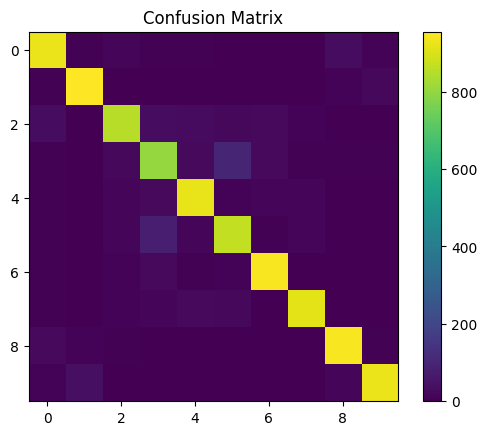

In [13]:
model_pretrained_mod3 = get_model_pretrained()
model_pretrained_mod3.conv1 = nn.Conv2d(3, 64, kernel_size=(3,3), stride=(1, 1), padding=(1,1), bias=False).to(device)
model_pretrained_mod3.maxpool = nn.MaxPool2d(kernel_size=1, stride=1)

# training
train_model(model_pretrained_mod3, train_loader_small, val_loader_small, log_wandb='pretrained_mod3')

# evaluation
print("Train Set")
evaluate_model(model_pretrained_mod3, train_loader_small)
print("Validation Set")
evaluate_model(model_pretrained_mod3, val_loader_small)
print("Test Set")
evaluate_modified_model(model_pretrained_mod3, test_loader_small)

Modifications:
1. Reducing kernel size and stride in the first convolutional layer to capture more spatial features. This method allows the model to capture more spatial features in the initial layers without discarding information leading to slightly better accuracy.
2. Updating the maxpool kernel size and stride to 1. Basically, removing the maxpool layer to retain spatial information. This prevents any loss of information due to downsampling, since the images are already small. This leads to significantly better accuracy.
3. Combining both modifications to see if the model can capture more spatial features and retain spatial information. This leads to the best accuracy.

Observations:
- The maxpool update is more effective compared to the conv1 update. 
- The model with both updates has the best accuracy.

![img](outputs/pretrained_mods_comparison.png)

In this case with the pretrained weights as initialization, the conv1 and maxpool layers are re-initialized from scratch. The rest of the layers are initialized with the pretrained weights from ImageNet. 
- Inconsistent feature distribution: The conv1 and maxpool layers learn features from the given dataset directly whereas the rest of the layers modify the learned features from ImageNet. This inconsistency in feature distribution can lead to suboptimal performance since the feature representation in the deeper layers depends on the initial layers.
- The randomly initialized first layer might provide different types of features, requiring deeper layers to adjust during training which could lead to slower convergence.
- As the number of training epochs increases, the deeper layers might adjust to the features learned by the first layer, leading to improved performance.

## Comparison

Table summarizing the results of the models.
| Model | Image Size | Accuracy | F1 Score |
| --- | --- | --- | --- |
| Random Init | 32x32 | 77.92% | 0.7791 |
| Random Init | 224x224 | 85.32% | 0.8531 |
| Pretrained | 32x32 | 83.82% | 0.8381 |
| Pretrained | 224x224 | 91.89% | 0.9188 |
| Random Init - Mod 1 | 32x32 | 82.35% | 0.8232 |
| Random Init - Mod 2 | 32x32 | 79.65% | 0.7963 |
| Random Init - Mod 3 | 32x32 | 84.99% | 0.8494 |
| Pretrained - Mod 1 | 32x32 | 81.81% | 0.8188 |
| Pretrained - Mod 2 | 32x32 | 89.17% | 0.8915 |
| Pretrained - Mod 3 | 32x32 | 90.63% | 0.9062 |

In [33]:
results_df = pd.DataFrame({
    "Model": [
        "Random Init", "Random Init",
        "Random Init - Mod 1", "Random Init - Mod 2", "Random Init - Mod 3",
         "Pretrained", "Pretrained", 
        "Pretrained - Mod 1", "Pretrained - Mod 2", "Pretrained - Mod 3"
    ],
    "Image Size": [
        "32x32", "224x224",
        "32x32", "32x32", "32x32",
        "32x32", "224x224", 
        "32x32", "32x32", "32x32"
    ],
    "Accuracy": [
        77.92, 85.32,
        82.35, 79.65, 84.99,
        83.82, 91.89,
        81.81, 89.17, 90.63
    ],
    "F1 Score": [
        0.7791, 0.8531,
        0.8232, 0.7963, 0.8494,
        0.8381, 0.9188,
        0.8188, 0.8915, 0.9062
    ]
})

### Pretrained vs Random Initialization

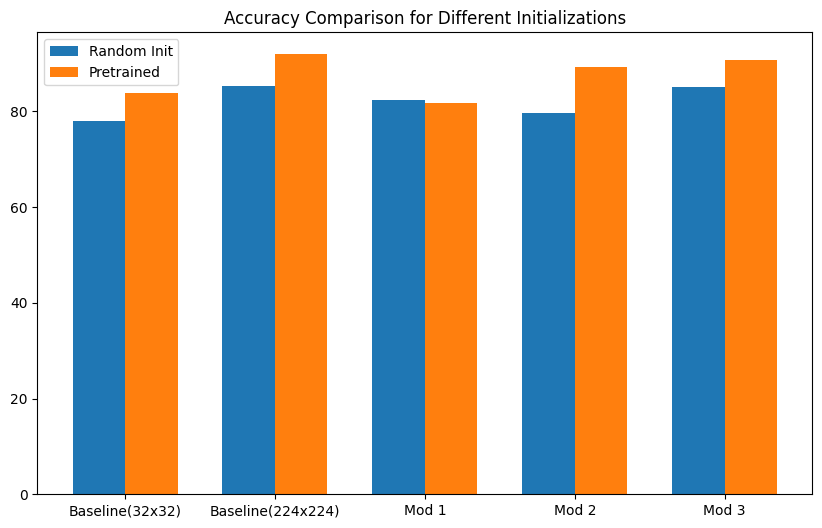

In [39]:
# show bar plot of results_df accuracy for each kind with 2 subbars together for pretrained and random init
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
bar1 = ax.bar(np.arange(5), results_df["Accuracy"].iloc[:5], bar_width, label="Random Init")
bar2 = ax.bar(np.arange(5) + bar_width, results_df["Accuracy"].iloc[5:], bar_width, label="Pretrained")
ax.set_xticks(np.arange(5) + bar_width / 2)
ax.set_xticklabels(["Baseline(32x32)", "Baseline(224x224)", "Mod 1", "Mod 2", "Mod 3"])
ax.legend()
plt.title("Accuracy Comparison for Different Initializations")
plt.show()


The pretrained model has a higher accuracy compared to the model trained from scratch. The pretrained model starts with a lower training loss and achieves better accuracy and stability due to learned features from ImageNet.

### Size of Image

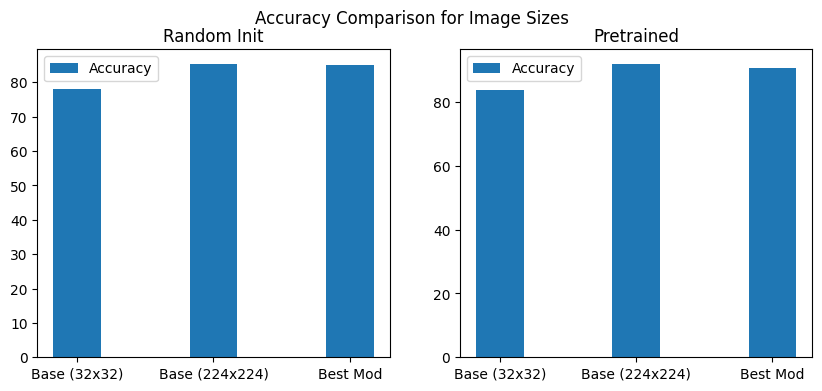

In [48]:
# show bar plot of baseline (32), mod 3 and baseline (224) in two subplots for each initialization
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
bar_width = 0.35
bar1 = ax[0].bar(np.arange(3), results_df["Accuracy"].iloc[[0, 1, 4]], bar_width, label="Accuracy")
ax[0].set_xticks(np.arange(3))
ax[0].set_xticklabels(["Base (32x32)", "Base (224x224)", "Best Mod"])
ax[0].legend()
ax[0].set_title("Random Init")

bar2 = ax[1].bar(np.arange(3), results_df["Accuracy"].iloc[[5, 6, 9]], bar_width, label="Accuracy")
ax[1].set_xticks(np.arange(3))
ax[1].set_xticklabels(["Base (32x32)", "Base (224x224)", "Best Mod"])
ax[1].legend()
ax[1].set_title("Pretrained")

plt.suptitle("Accuracy Comparison for Image Sizes")
plt.show()

The models trained on 224x224 images have higher accuracy compared to the models trained on 32x32 images. This is because the model actually gets to convolutional layers to extract spatial features from the images. The models trained on 224x224 images take longer to train compared to the models trained on 32x32 images. This happens as the convolutional layers have to process more pixels in the image.

Based on modifications to the architecture, the model can be learnt to capture more spatial features and retain spatial information from the 32x32 images as well. This achieves similar accuracy to the models trained on 224x224 images while taking less time to train due to fewer pixels in the image.

### Modifications to Architecture

In both cases of random initialization and pretrained weights as initialization, the model with both modifications achieves the best accuracy but is slightly lesser than the model trained on 224x224 images. 

In case of random initialization, since all layers are trained from scratch, the best modificaition model has almost the exact same results as the model trained on 224x224 images.

In case of pretrained weights as initialization, the model with both modifications has slightly lesser accuracy compared to the model trained on 224x224 images. This is because the conv1 and maxpool layers are re-initialized from scratch and the feature distribution is inconsistent. The model trained on 224x224 images has consistent feature distribution from the initial layers to the deeper layers.

### F1 Score and Confusion Matrix

The F1 score is a measure of a model's accuracy on a dataset. It is the harmonic mean of precision and recall. The F1 score is a better measure of a model's performance compared to accuracy. 

The multiclass confusion matrix of the best model is shown for all the modified models in the notebook. The confusion matrix shows the true positive, false positive, true negative and false negative values for each class. The diagonal values show the correct predictions for each class. The off-diagonal values show the incorrect predictions for each class.

- The similar values for accuracy and F1 score show that the model is consistent in its predictions across all classes. The confusion matrix shows that the model is able to predict most of the classes correctly. 
- If the model had a high accuracy but a low F1 score, it would mean that the model is not consistent in its predictions across all classes. The confusion matrix would show that the model is not able to predict some classes correctly.

Reason for difference in accuracy and F1 score:
- The accuracy is calculated as the ratio of correct predictions to the total number of predictions. The accuracy does not take into account the false positives and false negatives.
- The F1 score is calculated as the harmonic mean of precision and recall. The F1 score takes into account the false positives and false negatives. The F1 score is a better measure of a model's performance compared to accuracy.
- The pretrained model has a higher accuracy compared to the model trained from scratch.
- Larger image size leads to higher accuracy and F1 score. The model trained on 224x224 images has higher accuracy and F1 score compared to the model trained on 32x32 images.